In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
import logging
import json
import re
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [15]:
class Args():
    def __init__(self, input_file=None, output_file=None, bert_model=None, do_lower_case=False, layers="-1,-2,-3,-4", max_seq_length=128, batch_size=16, local_rank=-1, no_cuda=False):
        self.input_file = input_file
        self.output_file = output_file
        self.bert_model = bert_model
        self.do_lower_case = do_lower_case
        self.layers = layers
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size
        self.local_rank = local_rank
        self.no_cuda = no_cuda

In [3]:
from data_load import NerDataset, pad, VOCAB, tokenizer, tag2idx, idx2tag

input_file = '/home/cilab/LabMembers/YS/WWW/finetuning/train.txt'
output_file = 'inspect_output.jsonl'
#bert_model = '/home/cilab/LabMembers/YS/bert_ner/bert_model/scibert_scivocab_uncased'
bert_model = '/home/cilab/LabMembers/YS/bert_ner/new_new_new_model_by_kp20/6.pt'
layers = '-1,-5'
max_seq_length = 256
batch_size = 1

args = Args(
    input_file=input_file, 
    output_file=output_file,
    bert_model=bert_model, 
    layers=layers, 
    max_seq_length=max_seq_length,
    batch_size=batch_size
)

if args.local_rank == -1 or args.no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    device = torch.device("cuda", args.local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device: {} n_gpu: {} distributed training: {}".format(device, n_gpu, bool(args.local_rank != -1)))

layer_indexes = [int(x) for x in args.layers.split(",")]

01/20/2020 20:52:23 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /home/cilab/.cache/torch/pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
01/20/2020 20:52:23 - INFO - __main__ -   device: cuda n_gpu: 4 distributed training: False


In [4]:
from torch.utils import data

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

eval_dataset = NerDataset(args.input_file)

01/20/2020 20:52:29 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /home/cilab/.cache/torch/pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


In [5]:
import torch
import torch.nn as nn
from pytorch_pretrained_bert import BertModel

class Net(nn.Module):
    def __init__(self, top_rnns=False, vocab_size=None, device='cpu', finetuning=False, bert_type='bert-base-cased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_type)

        self.top_rnns=top_rnns
        if top_rnns:
            self.rnn = nn.LSTM(bidirectional=True, num_layers=2, input_size=768, hidden_size=768//2, batch_first=True)
        self.fc = nn.Linear(768, vocab_size)

        self.device = device
        self.finetuning = finetuning

    def forward(self, x, y, ):
        '''
        x: (N, T). int64
        y: (N, T). int64
        Returns
        enc: (N, T, VOCAB)
        '''
        x = x.to(self.device)
        y = y.to(self.device)
        
        if self.training and self.finetuning:
            # print("->bert.train()")
            self.bert.train()
            encoded_layers, _ = self.bert(x)
            enc = encoded_layers[-1]
        else:
            self.bert.eval()
            with torch.no_grad():
                encoded_layers, _ = self.bert(x)
                enc = encoded_layers[-1]

        if self.top_rnns:
            enc, _ = self.rnn(enc)
        logits = self.fc(enc)
        y_hat = logits.argmax(-1)
        return encoded_layers, logits, y, y_hat

In [32]:
kp20 = Net(True, len(VOCAB), device, False).cuda()
kp20_checkpoint = torch.load('/home/cilab/LabMembers/YS/bert_ner/new_new_new_model_by_kp20/6.pt')
kp20.load_state_dict(kp20_checkpoint['model_state_dict'],strict=False)

01/20/2020 04:27:40 - INFO - pytorch_pretrained_bert.modeling -   loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model.bin from cache at /home/cilab/.cache/torch/pytorch_pretrained_bert/35d8b9d36faaf46728a0192d82bf7d00137490cd6074e8500778afed552a67e5.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2
01/20/2020 04:27:40 - INFO - pytorch_pretrained_bert.modeling -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/cilab/.cache/torch/pytorch_pretrained_bert/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
01/20/2020 04:27:40 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

<All keys matched successfully>

In [33]:
pretrained_bert = Net(True, len(VOCAB), device, False).cuda()

01/20/2020 04:27:53 - INFO - pytorch_pretrained_bert.modeling -   loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model.bin from cache at /home/cilab/.cache/torch/pytorch_pretrained_bert/35d8b9d36faaf46728a0192d82bf7d00137490cd6074e8500778afed552a67e5.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2
01/20/2020 04:27:53 - INFO - pytorch_pretrained_bert.modeling -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/cilab/.cache/torch/pytorch_pretrained_bert/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
01/20/2020 04:27:53 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

In [34]:
scibert = Net(True, len(VOCAB), device, False, bert_type='bert_model/scibert_scivocab_uncased').cuda()
#scibert_checkpoint = torch.load(args.bert_model)
#scibert.load_state_dict(kp20_checkpoint['model_state_dict'],strict=False)

01/20/2020 04:27:54 - INFO - pytorch_pretrained_bert.modeling -   loading weights file bert_model/scibert_scivocab_uncased/pytorch_model.bin
01/20/2020 04:27:54 - INFO - pytorch_pretrained_bert.modeling -   loading configuration file bert_model/scibert_scivocab_uncased/config.json
01/20/2020 04:27:54 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 31090
}



In [35]:
def get_embeddings_layer(model):
    embeddings_layer = list(model.modules())[2]
    return embeddings_layer.cuda()

kp20_path = "../kp20k/finetuning/train_20.txt"
kp40_path = "../kp20k/finetuning/train_40.txt"
kp60_path = "../kp20k/finetuning/train_60.txt"

kp20_dataset = NerDataset(kp20_path)
kp40_dataset = NerDataset(kp40_path)
kp60_dataset = NerDataset(kp60_path)

kp20_dataloader = data.DataLoader(dataset=kp20_dataset,
                                 batch_size=args.batch_size,
                                 shuffle=False,
                                 num_workers=4,
                                 collate_fn=pad)
kp40_dataloader = data.DataLoader(dataset=kp40_dataset,
                                 batch_size=args.batch_size,
                                 shuffle=False,
                                 num_workers=4,
                                 collate_fn=pad)
kp60_dataloader = data.DataLoader(dataset=kp60_dataset,
                                 batch_size=args.batch_size,
                                 shuffle=False,
                                 num_workers=4,
                                 collate_fn=pad)

from pytorch_pretrained_bert.modeling import BertEmbeddings

for path in [kp20_path, kp40_path, kp60_path]:
    with open(path, 'r') as f:
        corpus = ""
        for i, l in enumerate(tqdm(f.read().split('\n'))):
            if i==0:
                continue
            piece = l.split(' ')[0]
            if "DOCSTART" in piece:
                continue
            corpus += piece + '\n'
        with open("./kp_vocab/"+path.split('/')[-1].replace('.txt', '')+"origin.txt", 'wt') as f2:
            f2.write(corpus)

def make_vocab(dataloader, path):
    token_counter = set()
    for i, batch in enumerate(tqdm(dataloader)):
        words, x, is_heads, tags, y, seqlens = batch
        for word in words:
            for index, (token, l) in enumerate(zip(tokenizer.tokenize(word), y.numpy()[0])):
                if token in ['[CLS]', '[SEP]']:
                    continue
                token_counter.add(token.lower())
    special = ['[UNK]', '[CLS]', '[SEP]', '[MASK]']
    for token in special:
        token_counter.add(token)
    with open(path, 'w') as f:
        for token in token_counter:
            f.write(token+'\n')
for loader, path in [(kp20_dataloader, "./kp_vocab/kp20_vocab.txt"), (kp40_dataloader, "./kp_vocab/kp40_vocab.txt"), (kp60_dataloader, "./kp_vocab/kp60_vocab.txt")]:
    make_vocab(loader, path)

kp20_vocab = './kp_vocab/kp20_vocab.txt'
kp40_vocab = './kp_vocab/kp40_vocab.txt'
kp60_vocab = './kp_vocab/kp60_vocab.txt'

vocab_size = {}

with open(kp20_vocab, 'r+') as f:
    vocab_size['20'] = len(f.read().split('\n'))
with open(kp40_vocab, 'r+') as f:
    vocab_size['40'] = len(f.read().split('\n'))
with open(kp60_vocab, 'r+') as f:
    vocab_size['60'] = len(f.read().split('\n'))

In [47]:
vocab_size

{'20': 20151, '40': 21195, '60': 21682}

In [19]:
28996+20151

49147

In [20]:
28996+21195

50191

In [21]:
28996+21682

50678

In [22]:
scibert

Net(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
   

In [18]:
pretrained_bert

Net(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
   

In [17]:
kp20

Net(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49147, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (interme

In [48]:
from pytorch_pretrained_bert.modeling import BertEmbeddings

In [73]:
kp20.bert.embeddings.word_embeddings = nn.Embedding(49147, 768)

In [74]:
kp20

Net(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49147, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (interme

In [75]:
eval_dataloader = data.DataLoader(dataset=eval_dataset,
                                 batch_size=args.batch_size,
                                 shuffle=False,
                                 num_workers=4,
                                 collate_fn=pad)

In [92]:
from tqdm import tqdm
import pandas as pd
import numpy as np

torch.manual_seed(5)
torch.cuda.manual_seed_all(5)

def get_sample(model, iterater):
    model.eval()
    unique_id = 0

    break_point = False
    
    df_id, df_token, df_feat, df_y, df_pred = [], [], [], [], []
    for i, batch in enumerate(tqdm(eval_dataloader)):
        if i<2:
            continue
        elif i==3:
            break
        #input_ids = input_ids.to(device)
        #input_mask = input_mask.to(device)
        words, x, is_heads, tags, y, seqlens = batch
        #print(words)
        #print(tags)
        #print(y)
        #print(y.numpy()[0])
        #for w, l in zip(tokenizer.tokenize(words[0]), y.numpy()[0]):
        #    print(l, w)
        with torch.no_grad():
            embeddings = model(x.cuda(), token_type_ids=None)
        embeddings = embeddings.squeeze()
        #print(all_encoder_layers)
        for word in words:
            for index, (token, l) in enumerate(zip(tokenizer.tokenize(word), y.numpy()[0])):
                if token in ['[CLS]', '[SEP]']:
                    continue
                df_id.append(unique_id)
                df_token.append(token)
                df_feat.append(embeddings[index].cpu().detach().numpy())
                df_y.append(l)
                unique_id += 1
        #print(tags)
        #print(embeddings.shape)
    df_feat = np.array(df_feat)
    feat_cols = ['feat'+str(i) for i in range(df_feat.shape[1])]
    df = pd.DataFrame(df_feat, columns=feat_cols)
    df['id'] = df_id
    df['token'] = df_token
    df['label'] = df_y
    
    return df, feat_cols

In [111]:
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compose_2d(df, feat_cols):
    tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=300, random_state=1)
    #verbose=1, perplexity=40, 
    tsne_results = tsne.fit_transform(df.loc[:,feat_cols].values)
    return tsne_results

In [112]:
plot_data = []

for model in [pretrained_bert, kp20, scibert]:
    emb_layer = get_embeddings_layer(model)
    df, cols = get_sample(emb_layer, eval_dataloader)
    feat = compose_2d(df, cols)
    plot_data.append((df, feat))




  0%|          | 0/6981 [00:00<?, ?it/s]


  0%|          | 1/6981 [00:01<2:06:15,  1.09s/it]



  0%|          | 0/6981 [00:00<?, ?it/s]

[t-SNE] Computing 18 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 6.155820
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.031166
[t-SNE] KL divergence after 300 iterations: 0.401843





  0%|          | 1/6981 [00:01<2:03:58,  1.07s/it]



  0%|          | 0/6981 [00:00<?, ?it/s]

[t-SNE] Computing 18 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.800755
[t-SNE] KL divergence after 300 iterations: 0.418239





  0%|          | 1/6981 [00:00<1:30:29,  1.29it/s]

[t-SNE] Computing 18 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 12.252189
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.995750
[t-SNE] KL divergence after 300 iterations: 0.550009


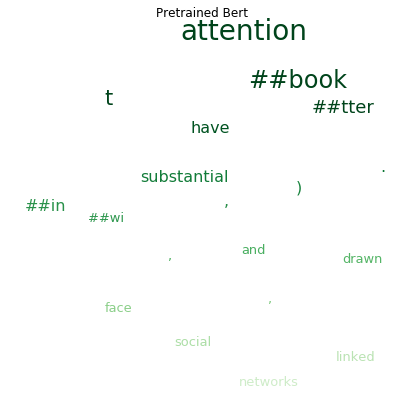

<Figure size 432x288 with 0 Axes>

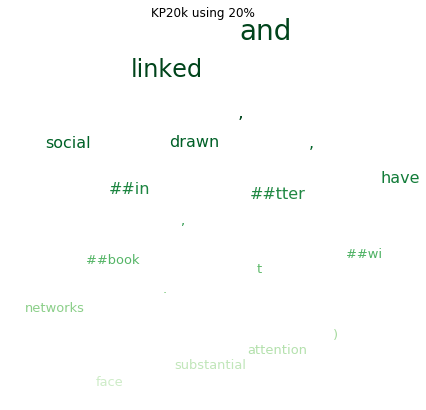

<Figure size 432x288 with 0 Axes>

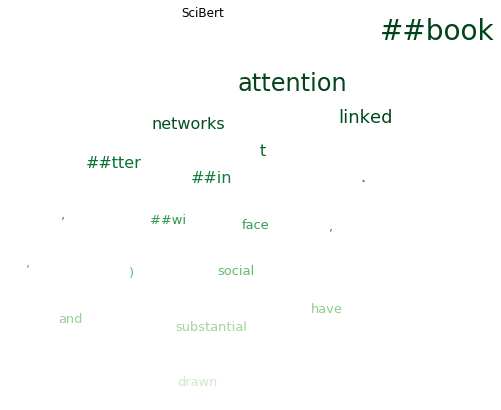

<Figure size 432x288 with 0 Axes>

In [113]:
%matplotlib inline
def get_plot(df, tsne_results, title):
    gcm = plt.get_cmap('Greens')
    plt.figure(figsize=(7, 7))
    #plt.tight_layout(-0.3)
    plt.axis('off')
    #plt.margins(x=-0.4,y=-0.4)
    #plt.tight_layout()
    plt.title(title)
    plt.xticks([], [])
    plt.yticks([], [])
    norm = plt.Normalize(tsne_results[:, 1].min(), tsne_results[:, 1].max())
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], marker=None, s=0)
    for i, word in enumerate(df['token']):
        if norm(tsne_results[i, 1]) < 0.5:
            font_size = 13
        elif norm(tsne_results[i, 1]) >= 0.5 and norm(tsne_results[i, 1]) < 0.75:
            font_size = 16
        elif norm(tsne_results[i, 1]) >= 0.75 and norm(tsne_results[i, 1]) < 0.8:
            font_size = 18
        elif norm(tsne_results[i, 1]) >= 0.8 and norm(tsne_results[i, 1]) < 0.85:
            font_size = 21
        elif norm(tsne_results[i, 1]) >= 0.8 and norm(tsne_results[i,
                                                                   1]) < 0.9:
            font_size = 24
        else:
            font_size = 28
        plt.annotate(word, xy=(tsne_results[i, 0], tsne_results[i, 1]), fontsize=font_size, color=gcm(norm(tsne_results[i, 1])+0.22))
        #plt.annotate(word, xy=(tsne_results[i, 0], tsne_results[i, 1]), fontsize=round(font_size)%30)
    plt.show()
    plt.savefig('emb_result/'+'gg'+'.png') 

title = ["Pretrained Bert", "KP20k using 20%", "SciBert"]
for i, (df, feat) in enumerate(plot_data):
    get_plot(df, feat.copy(), title[i])